Position RMSE: 0.4365
Velocity RMSE: 0.1656


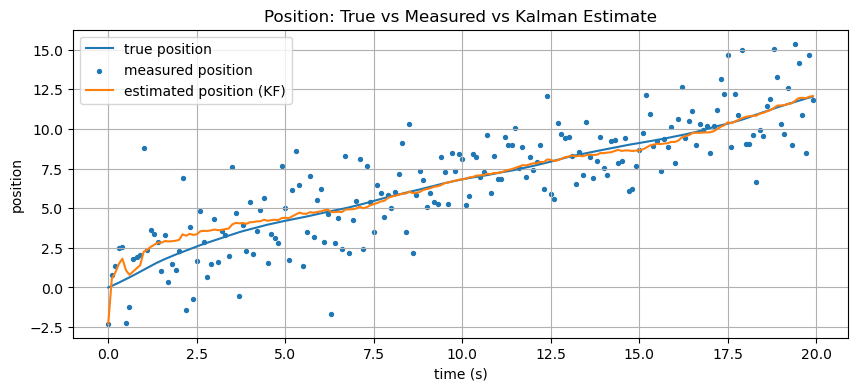

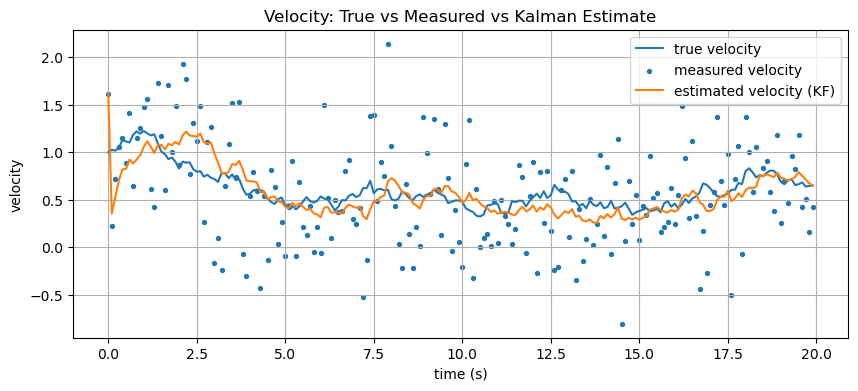

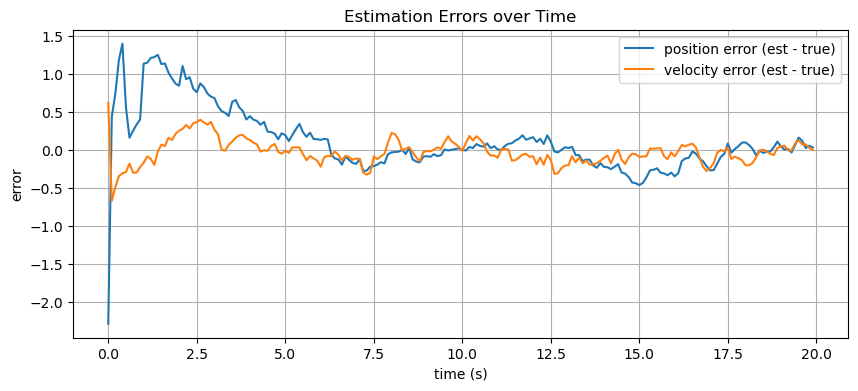

In [4]:
# Simulate and run a 1D Kalman filter (position + velocity) with noisy position & speed measurements
# The code will:
# - Simulate true motion with small acceleration noise
# - Generate noisy position and velocity measurements
# - Implement a discrete-time Kalman filter for state [position, velocity]
# - Run filter
# - Plot results (one figure per chart)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

np.random.seed(42)

# Simulation parameters
dt = 0.1                    # time step (s)
T = 20.0                    # total time (s)
N = int(T / dt)             # number of steps
t = np.arange(N) * dt

# True-motion parameters
# We'll model true motion as constant-acceleration driven by white acceleration noise
true_pos0 = 0.0
true_vel0 = 1.0
accel_std = 0.5             # std of random acceleration (process driving noise)

# Measurement noise (position and velocity)
meas_pos_std = 2.0          # position measurement noise std
meas_vel_std = 0.5          # velocity measurement noise std

# Process noise parameter q (spectral density of acceleration noise)
q = accel_std**2

# State matrices for constant velocity model (state = [pos, vel])
F = np.array([[1.0, dt],
              [0.0, 1.0]])
H = np.eye(2)  # we measure both position and velocity directly
# Discrete-time process noise covariance Q for white acceleration input:
Q = q * np.array([[dt**4/4, dt**3/2],
                  [dt**3/2, dt**2]])
# Measurement noise covariance
R = np.diag([meas_pos_std**2, meas_vel_std**2])

# Simulate true trajectory
true_states = np.zeros((N, 2))
true_states[0, :] = [true_pos0, true_vel0]
for k in range(1, N):
    # accelerate with zero-mean white noise
    a = np.random.randn() * accel_std
    # continuous model: p += v*dt + 0.5*a*dt^2 ; v += a*dt
    p_prev, v_prev = true_states[k-1]
    p = p_prev + v_prev*dt + 0.5*a*dt*dt
    v = v_prev + a*dt
    true_states[k] = [p, v]

# Generate noisy measurements
meas = np.zeros_like(true_states)
meas[:, 0] = true_states[:, 0] + np.random.randn(N) * meas_pos_std
meas[:, 1] = true_states[:, 1] + np.random.randn(N) * meas_vel_std

# Kalman filter implementation
x_est = np.zeros((N, 2))   # state estimates
P_est = np.zeros((N, 2, 2))# state covariances

# initial guess
x_est[0] = [meas[0,0], meas[0,1]]   # naive: start at first measurement
P_est[0] = np.diag([meas_pos_std**2, meas_vel_std**2]) * 10.0  # large uncertainty

for k in range(1, N):
    # Predict
    x_pred = F @ x_est[k-1]
    P_pred = F @ P_est[k-1] @ F.T + Q

    # Update with measurement
    z = meas[k]
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    y = z - (H @ x_pred)
    x_upd = x_pred + K @ y
    P_upd = (np.eye(2) - K @ H) @ P_pred

    x_est[k] = x_upd
    P_est[k] = P_upd

# Compute RMSE
pos_rmse = np.sqrt(np.mean((x_est[:,0] - true_states[:,0])**2))
vel_rmse = np.sqrt(np.mean((x_est[:,1] - true_states[:,1])**2))

print(f"Position RMSE: {pos_rmse:.4f}")
print(f"Velocity RMSE: {vel_rmse:.4f}")

# Prepare results DataFrame
df = pd.DataFrame({
    'time': t,
    'true_pos': true_states[:,0],
    'meas_pos': meas[:,0],
    'est_pos': x_est[:,0],
    'true_vel': true_states[:,1],
    'meas_vel': meas[:,1],
    'est_vel': x_est[:,1],
})

# Plot 1: Position (true, measurements, estimate)
plt.figure(figsize=(10,4))
plt.plot(t, df['true_pos'], label='true position')
plt.scatter(t, df['meas_pos'], s=8, label='measured position')
plt.plot(t, df['est_pos'], label='estimated position (KF)')
plt.xlabel('time (s)')
plt.ylabel('position')
plt.title('Position: True vs Measured vs Kalman Estimate')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Velocity (true, measurements, estimate)
plt.figure(figsize=(10,4))
plt.plot(t, df['true_vel'], label='true velocity')
plt.scatter(t, df['meas_vel'], s=8, label='measured velocity')
plt.plot(t, df['est_vel'], label='estimated velocity (KF)')
plt.xlabel('time (s)')
plt.ylabel('velocity')
plt.title('Velocity: True vs Measured vs Kalman Estimate')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Estimation errors
plt.figure(figsize=(10,4))
plt.plot(t, x_est[:,0] - true_states[:,0], label='position error (est - true)')
plt.plot(t, x_est[:,1] - true_states[:,1], label='velocity error (est - true)')
plt.xlabel('time (s)')
plt.ylabel('error')
plt.title('Estimation Errors over Time')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# Print final few estimates and uncertainties
final_row = {
    'time': t[-1],
    'true_pos': true_states[-1,0],
    'est_pos': x_est[-1,0],
    'pos_std_est': np.sqrt(P_est[-1,0,0]),
    'true_vel': true_states[-1,1],
    'est_vel': x_est[-1,1],
    'vel_std_est': np.sqrt(P_est[-1,1,1]),
}
print("\nFinal estimate summary:")
for k,v in final_row.items():
    print(f"  {k}: {v:.4f}")




Final estimate summary:
  time: 19.9000
  true_pos: 12.0417
  est_pos: 12.0733
  pos_std_est: 0.3099
  true_vel: 0.6494
  est_vel: 0.6495
  vel_std_est: 0.1526
